In [2]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from copy import deepcopy
from ipywidgets import Output, VBox
import numpy as np
from scipy.fft import fft, fftshift
from scipy.signal.windows import hann
from scipy.signal import correlate
from typing import List
from cmtj.utils.linear import FieldScan
from cmtj.utils.filters import Filters
from collections import defaultdict
from tqdm.notebook import tqdm
from numpy.fft import fftfreq
import cmtj


def cross_detector(series: np.ndarray, N_periods: int):
    mean_point = (np.max(series) + np.min(series))/2. # midpoint 
    y_cross = series - mean_point
    change_points = []
    for i in range(series.shape[0] - 1):
        sign = np.sign(series[i])
        sign_n = np.sign(series[i + 1])
        if sign != sign_n:
            change_points.append(i)
    change_points = np.asarray(change_points)
    c_p_diff = change_points - np.roll(change_points, shift=1)
    if not c_p_diff.any():
        return series
    # take median 
    median = np.median(c_p_diff)
    # take the first point that follows the median 
    i = np.argmin(np.abs(c_p_diff - median)).ravel()[0]
    # assume that 
    start = change_points[i]
    if (i+N_periods*2) > len(change_points):
        x = len(change_points[i:])
        if x % 2 == 0: # if it's even don't 
            x -= 1 
        stop = change_points[x]
    else:
        stop = change_points[i+N_periods*2]
    return series[start:stop]


def compute_vsd(frequency, dynamicR, integration_step, dynamicI):
    SD = dynamicR*dynamicI
    SD -= np.mean(SD)
    SD *= hann(len(SD))
    # take full periods only 
    # SD = cross_detector(SD, N_periods=10)
    fs = 1.0 / integration_step
    nq = fs/2.
    if frequency == 0:
        frequency = 0.1
    # SD = Filters.butter_bandpass_filter(SD, pass_freq=(1.8*(frequency/nq), 2.2*(frequency/nq)), fs=fs, order=3)
    SD_dc = Filters.butter_lowpass_filter(SD, cutoff=10e6, fs=fs, order=3)
    SD_fft_org = fft(SD)*(2/len(SD))
    SD_fft = SD_fft_org[:len(SD) // 2]
    freqs_org = fftfreq(len(SD), integration_step)
    freqs = freqs_org[:len(SD) // 2]
    amplitude = np.abs(SD_fft)
    phase = np.angle(SD_fft)
    # first harmonic
    # argmax in range frequency
    # delete phase that's close to 0 

    fhar_index = np.argmin(np.abs(freqs-frequency))
    # second harmonic
    # argmax in range 2*frequency
    shar_index = np.argmin(np.abs(freqs - 2 * frequency))

    fhar_index = np.argsort(np.abs(freqs - frequency))[:5]  # neighbourhood
    max_fhar_amp_indx = np.argmax(SD_fft[fhar_index])
    # second harmonic
    # argmax in range 2*frequency
    shar_index = np.argsort(np.abs(freqs - 2*frequency))[:5]  # neighbourhood
    max_shar_amp_indx = np.argmax(SD_fft[shar_index])

    SD_fft_org = fftshift(SD_fft_org)
    freqs_org = fftshift(freqs_org)

    org_phase = np.angle(SD_fft_org)
    org_amp = np.abs(SD_fft_org)

    first_amp = amplitude[fhar_index][max_fhar_amp_indx]
    first_phase = phase[fhar_index][max_fhar_amp_indx]

    second_amp = amplitude[shar_index][max_shar_amp_indx]
    second_phase = phase[fhar_index][max_fhar_amp_indx]

    # take only positive frequencies 
    # pos_freqs = np.argmin(freqs[freqs >= 0] - 2*frequency)
    # second_phase = phase[freqs >= 0][pos_freqs]
    return np.mean(SD_dc), first_amp, first_phase, second_amp, second_phase, org_amp, org_phase, freqs_org

def calculate_resistance(Rx0, Ry0, AMR, AHE, SMR, m, number_of_layers, l, w):
    R_P = Rx0[0]
    R_AP = Ry0[0]

    if m.ndim == 2:
        SxAll = np.zeros((number_of_layers, ))
        SyAll = np.zeros((number_of_layers, ))

    elif m.ndim == 3:
        SxAll = np.zeros((number_of_layers, m.shape[2]))
        SyAll = np.zeros((number_of_layers, m.shape[2]))

    for i in range(0, number_of_layers):
        w_l = w[i] / l[i]
        SxAll[i] = 1 / (Rx0[i] + (AMR[i] * m[i, 0]**2 + SMR[i] * m[i, 1]**2))
        SyAll[i] = 1 / (Ry0[i] + 0.5 * AHE[i] * m[i, 2] + (w_l) *
                        (SMR[i] - AMR[i]) * m[i, 0] * m[i, 1])

    Rx = 1 / np.sum(SxAll, axis=0)
    Ry = 1 / np.sum(SyAll, axis=0)

    if number_of_layers > 1:
        Rz = R_P + ((R_AP - R_P) / 2) * (1 - np.sum(m[0, :] * m[1, :], axis=0))
    else:
        Rz = 0

    return Rx, Ry, Rz

In [3]:
from functools import partial
from typing import Tuple

import multiprocess as mp 
import matplotlib.pyplot as plt 


def setup() -> cmtj.Junction:
    dipole = [cmtj.CVector(0, 0, 0), cmtj.CVector(0, 0, 0), cmtj.CVector(0, 0, 0)]
    demag = [cmtj.CVector(0, 0, 0), cmtj.CVector(0, 0, 0), cmtj.CVector(0, 0, 1)]
    thickness = 1.45e-9
    l1_params = {
        "Ms": 0.5,
        "thickness":  thickness,
        "anis": cmtj.CVector(0, 0, 1.),
        "mag": cmtj.CVector(0, 0, 1.),
        "cellSurface": 1.0,
        "demagTensor": demag,
        "dipoleTensor": dipole,
        "damping": 0.004,
        "fieldLikeTorque": 5e-11,
        "dampingLikeTorque": 6e-11
    }

    l1 = cmtj.Layer.createSOTLayer(id="free", **l1_params)
    l1.setReferenceLayer(cmtj.CVector(0, 0, 1.))
    layer_str = ["free"]
    layers = [l1]
    junction = cmtj.Junction(layers=layers)
    junction.setLayerAnisotropyDriver("all", cmtj.ScalarDriver.getConstantDriver(1.8e5))

    return junction, thickness, layer_str

def run_simulation(H: Tuple, freq_scan: np.ndarray, s_time: float, int_step: float):
    hi, Hval = H
    junction, th, layer_str = setup()
    HDriver = cmtj.AxialDriver(cmtj.ScalarDriver.getConstantDriver(Hval[0]),
                               cmtj.ScalarDriver.getConstantDriver(Hval[1]),
                               cmtj.ScalarDriver.getConstantDriver(Hval[2]))
    junction.setLayerExternalFieldDriver("all", HDriver)
    Hoe = 7.5e6

    I_rf = 0.005 
    I_dc = 0
    I_dir = [1, 0, 0]

    j_rf_m = 0
    j_dc_m = 0 

    Rx0 = [186]
    Ry0 = [100]
    AMR = [-0.02]
    SMR = [-0.25]
    AHE = [-2.3]
    l = [3e-5]
    w = [2e-5]
    area = th * w[0]
    mags = [cmtj.CVector(*Hval) for _ in layer_str]
    result = []
    for fi, frequency in enumerate(freq_scan):
        junction.clearLog()
        # set mags for better convergence
        for i, l_str in enumerate(layer_str):
            junction.setLayerMagnetisation(l_str, mags[i])

        driver = cmtj.AxialDriver(
            cmtj.NullDriver(),
            cmtj.ScalarDriver.getSineDriver(Hoe * I_dc, Hoe * I_rf, frequency,
                                            0), cmtj.NullDriver())
        # set Oersted and current drivers
        junction.setLayerOerstedFieldDriver("all", driver)
        junction.setLayerCurrentDriver("all", 
                    cmtj.ScalarDriver.getConstantDriver(j_rf_m))
        junction.runSimulation(s_time, int_step, int_step)
        # set new mags 
        for str_ in layer_str:
            mags[i] = junction.getLayerMagnetisation(str_)

        log = junction.getLog()
        m = np.asarray([[
            log[f'{str_}_mx'], log[f'{str_}_my'],
            log[f'{str_}_mz']
        ] for str_ in layer_str])

        dynamicRx, dynamicRy, _ = calculate_resistance(Rx0, Ry0, AMR, AHE, SMR,
                                                       m, len(layer_str), l, w)

        lt = np.asarray(log['time'])
        # lt = lt[len(log['time'])//6:]
        dynamicRx = dynamicRx # [len(log['time'])//6:]
        dynamicRy = dynamicRy #[len(log['time'])//6:]
        dynamicI = I_dc + I_rf * \
            np.sin(2 * np.pi * frequency * lt)
        r = compute_vsd(dynamicR=dynamicRy,
                        frequency=frequency,
                        integration_step=int_step,
                        dynamicI=dynamicI)
        result.append((hi, fi, r, dynamicRy, dynamicI))
    return result


freq_scan = np.linspace(0.01e9, 0.02e9, num=4)
s_time = 3000e-9
int_step = 1e-12
steps = int(s_time / int_step)

Hscan, Hvecs = FieldScan.amplitude_scan(-800e3, 800e3, 30, 90, 0)
data = defaultdict(lambda: np.zeros((len(Hvecs), len(freq_scan))))
data2 = defaultdict(lambda: np.zeros((len(Hvecs), len(freq_scan), steps)))

with mp.Pool(8) as pool:
    with tqdm(total=len(Hscan)) as pbar:
        args = list(zip(np.arange(0, len(Hscan)), Hvecs))
        result = pool.imap_unordered(partial(run_simulation,
                                                freq_scan=freq_scan,
                                                s_time=s_time,
                                                int_step=int_step), args)
        for sub_result in result:
            for (hi, fi, res, dynamicRy, dynamicI) in sub_result:
                Rydc, Ryfirst_amp, Ryfirst_phase, Rysecond_amp, Rysecond_phase, a, phase, freqs = res
                data['Ry_1st_amplitude'][hi, fi] = Ryfirst_amp
                data['Ry_2nd_phase'][hi, fi] = Rysecond_phase
                data['Ry_2nd_amplitude'][hi, fi] = Rysecond_amp
                data['Ry_dc'][hi, fi] = Rydc
                data2['Ry_resistance'][hi, fi, :] = dynamicRy
                data2['Ry_mixing'][hi, fi, :] = dynamicRy * dynamicI
                data2['Ry_fft_phase'][hi, fi, :] = phase
                data2['Ry_fft'][hi, fi, :] = a
                data2['Ry_ftt_freqs'][hi, fi, :] = freqs
                
            pbar.update()

  0%|          | 0/30 [00:00<?, ?it/s]

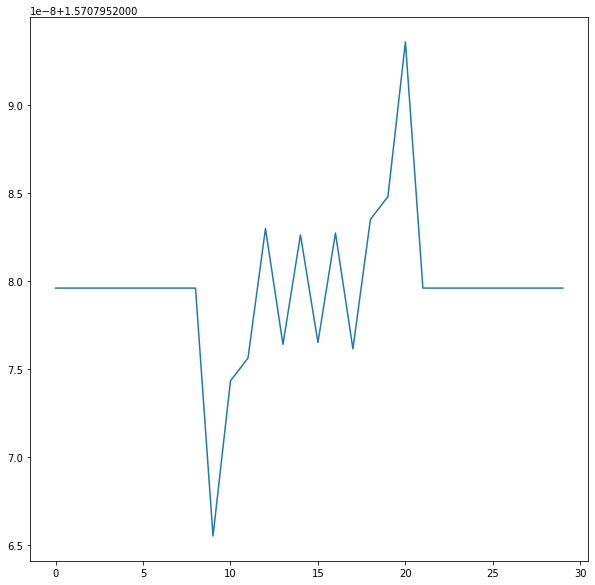

In [5]:
y = 1
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(data['Ry_2nd_phase'][:, y])
plt.show()

Text(0.5, 0, 'Frequency [MHz]')

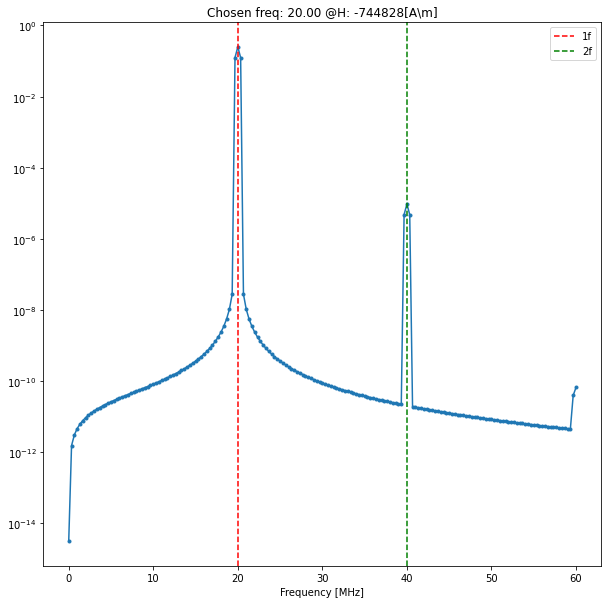

In [55]:
fig, ax = plt.subplots(figsize=(10, 10))

m_freq_scan = freq_scan/1e6
x = 1
y = 3
chosen_freq = m_freq_scan[y]
chosen_field = Hscan[x]
freqs = data2[f'Ry_ftt_freqs'][x, y]/1e6
freqs_mask = np.argwhere((freqs <= 3*chosen_freq) & (freqs >= 0)).ravel()
ax.semilogy(freqs[freqs_mask], data2['Ry_fft'][x, y, freqs_mask], '.-')
ax.axvline(x=chosen_freq, label="1f", color='r', linestyle='--')
ax.axvline(x=2*chosen_freq, label="2f", color='g', linestyle='--')
ax.set_title(f"Chosen freq: {chosen_freq:.2f} @H: {chosen_field:.0f}[A\m]")
ax.legend()
ax.set_xlabel("Frequency [MHz]")

In [42]:
data2[f'Ry_ftt_freqs']

array([[[-5.00000000e+11, -4.99999667e+11, -4.99999333e+11, ...,
          4.99999000e+11,  4.99999333e+11,  4.99999667e+11],
        [-5.00000000e+11, -4.99999667e+11, -4.99999333e+11, ...,
          4.99999000e+11,  4.99999333e+11,  4.99999667e+11],
        [-5.00000000e+11, -4.99999667e+11, -4.99999333e+11, ...,
          4.99999000e+11,  4.99999333e+11,  4.99999667e+11],
        [-5.00000000e+11, -4.99999667e+11, -4.99999333e+11, ...,
          4.99999000e+11,  4.99999333e+11,  4.99999667e+11]],

       [[-5.00000000e+11, -4.99999667e+11, -4.99999333e+11, ...,
          4.99999000e+11,  4.99999333e+11,  4.99999667e+11],
        [-5.00000000e+11, -4.99999667e+11, -4.99999333e+11, ...,
          4.99999000e+11,  4.99999333e+11,  4.99999667e+11],
        [-5.00000000e+11, -4.99999667e+11, -4.99999333e+11, ...,
          4.99999000e+11,  4.99999333e+11,  4.99999667e+11],
        [-5.00000000e+11, -4.99999667e+11, -4.99999333e+11, ...,
          4.99999000e+11,  4.99999333e+11,  4.99999

In [261]:
import numpy as np 
from cmtj.utils.filters import Filters

def quadrature_detection(reference_time: np.ndarray, input_signal: np.ndarray, reference_frequency: float, fs: float) -> float:
    # quadrature generation method 
    offset = np.pi/2 
    mixing_i = input_signal*np.sin(2*np.pi*reference_frequency*reference_time)
    mixing_q = input_signal*np.cos(2*np.pi*reference_frequency*reference_time)
    mixing_i = Filters.butter_lowpass_filter(mixing_i, cutoff=reference_frequency/fs, fs=fs)
    mixing_q = Filters.butter_lowpass_filter(mixing_q, cutoff=reference_frequency/fs, fs=fs)

    int_i = np.trapz(mixing_i)
    int_q = np.trapz(mixing_q)
    return np.arctan2(int_q, int_i) 

def second_harmonic_detector(signal: np.ndarray, reference_time: np.ndarray, reference_frequency: float) -> float:
    mixing = np.sin(2*np.pi*reference_time*reference_frequency)



f = 50e2
fs = f*2 # sample rate
T = 1/fs # sampling period
t = 1000 # seconds of sampling
N = int(fs*t) # total points in signal

x = np.linspace(0, 10*2*np.pi, num=N, endpoint=False)
signalA = 100*np.sin(2*np.pi*f*x + np.pi/4) + 1e-2*np.sin(2*np.pi*2*f*x + np.pi/3)
quadrature_detection(x, signalA, 2*f, fs=fs/2)

1.042250635820649

In [271]:
int_step = 1e-12
tm = 600e-9
f = 50e6

fs = (1.0/int_step)/2
x = np.arange(0, tm+int_step, step=int_step)
signalA = 100*np.sin(2*np.pi*f*x) + 10*np.sin(2*np.pi*2*f*x + np.pi/3)
filteredA = Filters.butter_lowpass_filter(signalA, cutoff=f/fs/2, fs=fs)
quadrature_detection(x, signalA, 2*f, fs=fs)

-2.8149535266501355

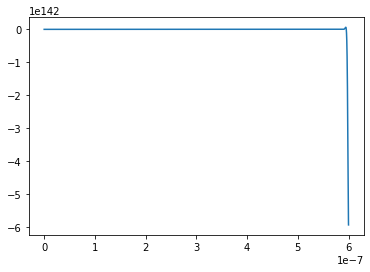

In [285]:
signalA = 100*np.sin(2*np.pi*f*x) + 100*np.sin(2*np.pi*2*f*x + np.pi/3)
filteredA = Filters.butter_lowpass_filter(signalA, cutoff=f/fs, fs=2*fs)
plt.plot(x, filteredA)
# plt.plot(x, signalA)

In [281]:
np.pi/3

1.0471975511965976